In [26]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


# Load training data
train = pd.read_csv('train.csv')

# Remove columns which have too many missing items
train2 = train.drop(['D_sms', 'D_sm1','D_tm0','D_Ra_Capacity','D_Ra_CDR'], axis=1)   

# Make up those missing items with averge  
train3 = train2.fillna(train2.mean())
X_train = train3.drop(['D_isR'], axis=1)
y_train = train['D_isR']


# Load test data
test = pd.read_csv('X_test.csv')
test2 = test.drop(['D_sms', 'D_sm1','D_tm0','D_Ra_Capacity','D_Ra_CDR'], axis=1)
X_test = test2.fillna(test2.mean())


# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)

scaler.fit(X_test)
X_test2 = scaler.transform(X_test)


# Training model
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

lr_clf = LogisticRegression(penalty='l1', solver='saga', random_state=42)

rf_clf = RandomForestClassifier(random_state=42)

svc_clf = SVC(random_state=42)

gbc_clf = GradientBoostingClassifier(learning_rate=0.1,random_state=42)

xgb_clf = XGBClassifier(learning_rate=0.05,n_estimators=450,max_depth=8,subsample=0.7,colsample_bytree=0.9)

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

# Voting classifier
voting_clf = VotingClassifier(
    estimators=[('gbc', gbc_clf), ('xgb', xgb_clf), ('ada', ada_clf), ('bag', bag_clf), ('lr', lr_clf), ('svc', svc_clf),
               ('rf', rf_clf)],
    voting='hard')

# PCA
pca = PCA(n_components=47, whiten=True)
model = make_pipeline(pca, voting_clf)

# Predict
model.fit(X_train2, y_train)
y_pred = model.predict(X_test2)


In [34]:
# Output predict data
label = y_pred
id = range(0,y_pred.shape[0])
y_pred2 = { "id": id, "label": label}  
y_pred3 = pd.DataFrame(y_pred2)
y_pred3.to_csv('C:/Users/USER/Desktop/midterm/y_pred.csv', index = False)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Cross validation
scores = cross_val_score(model, X_train2, y_train, cv=5, scoring='accuracy')
print(model.__class__.__name__, scores.mean())


In [110]:
# Grid search for hyper-parameters
parameters = {'n_estimators': [500,1000,2000,3000]}
grid_xgb = GridSearchCV( XGBClassifierClassifier(learning_rate=0.1), param_grid=parameters)
grid_xgb.fit(X_train2, y_train)
grid_xgb.best_params_
xgb_clf = grid_xgb.best_estimator_


D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 8}

In [17]:
# Feature importance
for name, score in zip(X_train.columns, xgb_clf.feature_importances_):
    print(name, score)


              precision    recall  f1-score   support

   D_is_notR       0.70      0.62      0.66       216
       D_isR       0.75      0.80      0.77       296

    accuracy                           0.73       512
   macro avg       0.72      0.71      0.72       512
weighted avg       0.72      0.73      0.72       512



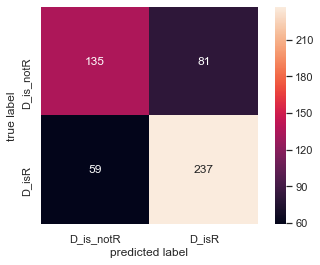

In [23]:
# Model performance analysis
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X_train2, y_train, random_state=42, test_size = 0.2)

model = xgb_clf
model.fit(Xtrain, ytrain)
y_pred = model.predict(Xtest)

mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d',
            xticklabels=['D_is_notR','D_isR'],
            yticklabels=['D_is_notR','D_isR'])
plt.xlabel('predicted label')
plt.ylabel('true label');

print(classification_report(ytest, y_pred, target_names=['D_is_notR','D_isR']))
